# Задание 3: Эксперименты с регуляризацией (25 баллов)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os
import torch.nn as nn

class ClassificationMetrics:
    def __init__(self):
        """
        Инициализация класса метрик классификации
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def to_one_hot(self, labels, num_classes):
        """
        Преобразование меток в one-hot encoding
        
        Args:
            labels: тензор меток (batch_size,)
            num_classes: количество классов
            
        Returns:
            one-hot тензор (batch_size, num_classes)
        """
        return torch.nn.functional.one_hot(labels, num_classes).float()

    def precision(self, y_true, y_pred, average='macro'):
        """
        Вычисление метрики Precision
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            average: тип усреднения ('macro', 'micro', 'weighted')
            
        Returns:
            precision score
        """
        y_true = torch.tensor(y_true, dtype=torch.long).to(self.device)
        y_pred = torch.tensor(y_pred, dtype=torch.long).to(self.device)
        
        num_classes = len(torch.unique(y_true))
        
        if average == 'micro':
            true_positives = torch.sum(y_true == y_pred).float()
            predicted_positives = len(y_pred)
            return true_positives / predicted_positives if predicted_positives > 0 else 0
        
        precision_per_class = []
        weights = []
        
        for c in range(num_classes):
            true_positives = torch.sum((y_true == c) & (y_pred == c)).float()
            predicted_positives = torch.sum(y_pred == c).float()
            
            precision = true_positives / predicted_positives if predicted_positives > 0 else 0
            precision_per_class.append(precision)
            
            if average == 'weighted':
                weights.append(torch.sum(y_true == c).float() / len(y_true))
        
        precision_per_class = torch.tensor(precision_per_class)
        
        if average == 'macro':
            return torch.mean(precision_per_class).item()
        elif average == 'weighted':
            return torch.sum(precision_per_class * torch.tensor(weights)).item()
        
        return precision_per_class.tolist()

    def recall(self, y_true, y_pred, average='macro'):
        """
        Вычисление метрики Recall
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            average: тип усреднения ('macro', 'micro', 'weighted')
            
        Returns:
            recall score
        """
        y_true = torch.tensor(y_true, dtype=torch.long).to(self.device)
        y_pred = torch.tensor(y_pred, dtype=torch.long).to(self.device)
        
        num_classes = len(torch.unique(y_true))
        
        if average == 'micro':
            true_positives = torch.sum(y_true == y_pred).float()
            actual_positives = len(y_true)
            return true_positives / actual_positives if actual_positives > 0 else 0
        
        recall_per_class = []
        weights = []
        
        for c in range(num_classes):
            true_positives = torch.sum((y_true == c) & (y_pred == c)).float()
            actual_positives = torch.sum(y_true == c).float()
            
            recall = true_positives / actual_positives if actual_positives > 0 else 0
            recall_per_class.append(recall)
            
            if average == 'weighted':
                weights.append(torch.sum(y_true == c).float() / len(y_true))
        
        recall_per_class = torch.tensor(recall_per_class)
        
        if average == 'macro':
            return torch.mean(recall_per_class).item()
        elif average == 'weighted':
            return torch.sum(recall_per_class * torch.tensor(weights)).item()
        
        return recall_per_class.tolist()

    def f1_score(self, y_true, y_pred, average='macro'):
        """
        Вычисление метрики F1-score
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            average: тип усреднения ('macro', 'micro', 'weighted')
            
        Returns:
            f1 score
        """
        precision = self.precision(y_true, y_pred, average)
        recall = self.recall(y_true, y_pred, average)
        
        if average in ['macro', 'weighted']:
            return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        elif average == 'micro':
            return precision
        
        f1_scores = []
        for p, r in zip(precision, recall):
            f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
            f1_scores.append(f1)
        return f1_scores

    def roc_auc(self, y_true, y_scores, multi_class='ovr'):
        """
        Вычисление метрики ROC-AUC
        
        Args:
            y_true: истинные метки (batch_size,)
            y_scores: вероятности предсказаний (batch_size, num_classes)
            multi_class: 'ovr' (one-vs-rest) или 'ovo' (one-vs-one)
            
        Returns:
            roc-auc score
        """
        y_true = torch.tensor(y_true, dtype=torch.long).cpu().numpy()
        y_scores = torch.tensor(y_scores, dtype=torch.float).cpu().numpy()
        
        num_classes = y_scores.shape[1]
        y_true_one_hot = self.to_one_hot(torch.tensor(y_true), num_classes).cpu().numpy()
        
        auc_scores = []
        
        if multi_class == 'ovr':
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_scores[:, i])
                auc_score = auc(fpr, tpr)
                auc_scores.append(auc_score)
            return np.mean(auc_scores)
        
        elif multi_class == 'ovo':
            auc_sum = 0
            n_pairs = 0
            for i in range(num_classes):
                for j in range(i+1, num_classes):
                    mask = np.logical_or(y_true == i, y_true == j)
                    y_true_binary = (y_true[mask] == i).astype(int)
                    y_scores_binary = y_scores[mask, i] / (y_scores[mask, i] + y_scores[mask, j])
                    fpr, tpr, _ = roc_curve(y_true_binary, y_scores_binary)
                    auc_sum += auc(fpr, tpr)
                    n_pairs += 1
            return auc_sum / n_pairs if n_pairs > 0 else 0
        
        return auc_scores

    def confusion_matrix(self, y_true, y_pred, plot=True, save_path=None):
        """
        Вычисление и визуализация confusion matrix с возможностью сохранения
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            plot: флаг для отображения визуализации
            save_path: путь для сохранения графика (например, 'confusion_matrix.png')
            
        Returns:
            confusion matrix
        """
        y_true = torch.tensor(y_true, dtype=torch.long).to(self.device)
        y_pred = torch.tensor(y_pred, dtype=torch.long).to(self.device)
        
        num_classes = len(torch.unique(y_true))
        cm = torch.zeros((num_classes, num_classes), dtype=torch.long)
        
        for t, p in zip(y_true, y_pred):
            cm[t, p] += 1
        
        if plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm.numpy(), annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            
            if save_path:
                # Создаём директорию, если она не существует
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Confusion matrix сохранена в {save_path}")
            
            plt.show()
            plt.close()
        
        return cm



from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import numpy as np
import torch

class CustomDataset(Dataset):
    def __init__(self, path_file, numeric_columns: list, string_columns: list, binary_columns: list, target_column: str):
        self.path_file = path_file
        self.numeric_columns = numeric_columns
        self.string_columns = string_columns
        self.binary_columns = binary_columns
        self.target_column = target_column
        self.label_encoders = {}
        self.one_hot_encoders = {}

        self.df = pd.read_csv(path_file)
        self.df = self.df.dropna()

        self._convert_numeric()
        self._convert_string()
        self._convert_binary()

    def _convert_numeric(self):
        if self.numeric_columns:
            scaler = StandardScaler()
            self.df[self.numeric_columns] = scaler.fit_transform(self.df[self.numeric_columns])

    def _convert_string(self):
        if self.string_columns:
            for column in self.string_columns:
                le = LabelEncoder()
                self.df[column] = self.df[column].fillna('missing')
                self.df[column] = le.fit_transform(self.df[column])
                self.label_encoders[column] = le

    def _convert_binary(self):
        if self.binary_columns:
            for column in self.binary_columns:
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                transformed = encoder.fit_transform(self.df[[column]])
                new_columns = [f"{column}_{cat}" for cat in encoder.categories_[0][1:]]
                self.df[new_columns] = transformed
                self.df = self.df.drop(column, axis=1)
                self.one_hot_encoders[column] = encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data_one_row = self.df.iloc[index]
        train = data_one_row.drop(self.target_column).values.astype(np.float32)  # Преобразуем в numpy float32
        target = np.array(data_one_row[self.target_column], dtype=np.float32)  # Преобразуем в numpy float32
        return torch.tensor(train), torch.tensor(target)  # Возвращаем тензоры

class LinearModel(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features,out_features)
    
    def forward(self,x):
        return self.layer1(x)

from torch.utils.data import DataLoader,SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  



def train_model(dataset,model):
    batch_size: int = 32,
    num_epochs: int = 100,
    learning_rate = 0.001,
    l1_lambda: float = 0.01,
    patience: int = 5,
    validation_split: float = 0.2
    lr = 0.001

    in_features = len(dataset.df.columns) - 1  # Все колонки, кроме целевой
    
    out_features = 1 

    #model_layer_1 = nn.Sequential(nn.Linear(in_features,1))
    model = model
    criterion = nn.BCEWithLogitsLoss()  # Функция потерь для регрессии
    optimizer = torch.optim.Adam(params =model.parameters(), lr=lr)

    # Разделяем данные на обучающую и валидационную выборки
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(
        indices, test_size=validation_split, random_state=42
    )

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    # Инициализируем раннюю остановку


    # Обучение
    print("Starting training...")
    arr_val_loss = []
    arr_train_loss = []
    for epoch in range(60):
        # Обучающий режим
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to( dtype=torch.float32), target.to(dtype=torch.float32)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to( dtype=torch.float32), target.to( dtype=torch.float32)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))  # Только MSE для валидации
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        arr_val_loss.append(avg_val_loss)
        arr_train_loss.append(avg_train_loss)
        if epoch%20==0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    plt.plot(arr_val_loss)
    plt.plot(arr_train_loss)
    plt.title(f"model_layer_{len(model)}")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(['Val', 'Train'], loc='upper left')  
    plt.savefig(f'plots/plots_wide_layers/model_layer_{len(model)}.png')
    plt.close()


from torch.utils.data import DataLoader,SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  



def train_model_with_accurasy(dataset,model,name_model):
    batch_size: int = 32,
    num_epochs: int = 50,
    learning_rate = 0.001,
    l1_lambda: float = 0.01,
    patience: int = 5,
    validation_split: float = 0.2
    lr = 0.001

    in_features = len(dataset.df.columns) - 1  # Все колонки, кроме целевой
    
    out_features = 1 

    #model_layer_1 = nn.Sequential(nn.Linear(in_features,1))
    model = model
    criterion = nn.BCEWithLogitsLoss()  # Функция потерь для регрессии
    optimizer = torch.optim.Adam(params =model.parameters(), lr=lr)

    # Разделяем данные на обучающую и валидационную выборки
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(
        indices, test_size=validation_split, random_state=42
    )

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    # Инициализируем раннюю остановку


    # Обучение
    print("Starting training...")
    arr_val_accurasy = []
    arr_train_accurasy = []
    for epoch in range(50):
        # Обучающий режим
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to( dtype=torch.float32), target.to(dtype=torch.float32)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Вычисляем точность для тренировочной выборки
            preds = (torch.sigmoid(output) > 0.5).float()  # Преобразуем логиты в предсказания (0 или 1)
            train_correct += (preds == target.view(-1, 1)).sum().item()
            train_total += target.size(0)
            
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        
        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to( dtype=torch.float32), target.to( dtype=torch.float32)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))  # Только MSE для валидации
                val_loss += loss.item()

                # Вычисляем точность для валидационной выборки
                preds = (torch.sigmoid(output) > 0.5).float()  # Преобразуем логиты в предсказания
                val_correct += (preds == target.view(-1, 1)).sum().item()
                val_total += target.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        arr_val_accurasy.append(val_accuracy)
        arr_train_accurasy.append(train_accuracy)
        
        if epoch%20==0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    plt.plot(arr_val_accurasy)
    plt.plot(arr_train_accurasy)
    plt.title(f"model_layer_{model_name}")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(['Val', 'Train'], loc='upper left')  
    plt.savefig(f'plots/plots_3_chapter/{model_name}.png')
    plt.close()

3.1 Сравнение техник регуляризации (15 баллов)
 Исследуйте различные техники регуляризации:
 - Без регуляризации
 - Только Dropout (разные коэффициенты: 0.1, 0.3, 0.5)
 - Только BatchNorm
 - Dropout + BatchNorm
 - L2 регуляризация (weight decay)
 
 Для каждого варианта:
 - Используйте одинаковую архитектуру
 - Сравните финальную точность
 - Проанализируйте стабильность обучения
 - Визуализируйте распределение весов

Сделаю модель с архитеркутурой 16-32-16 и к ней уже все добавлять

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def plot_weight_histogram_sequential(model, model_name):
    # Список для хранения всех весов
    all_weights = []

    # Проходим по всем слоям модели
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):  # Проверяем, что слой — nn.Linear
            weights = module.weight.detach().cpu().numpy().flatten()  # Извлекаем и преобразуем веса
            all_weights.extend(weights)

    # Создаем гистограмму
    plt.figure(figsize=(10, 6))
    sns.histplot(all_weights, bins=50, kde=True, color='blue')
    plt.title(f"Распределение весов модели {model_name}")  # Используем переданное название
    plt.xlabel('Значение веса')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()




Тренировка базовой модели

Starting training...
Epoch 1/(50,), Train Loss: 1.402905, Val Loss: 0.890685
Epoch 21/(50,), Train Loss: 0.605305, Val Loss: 0.618843
Epoch 41/(50,), Train Loss: 0.629789, Val Loss: 0.701889


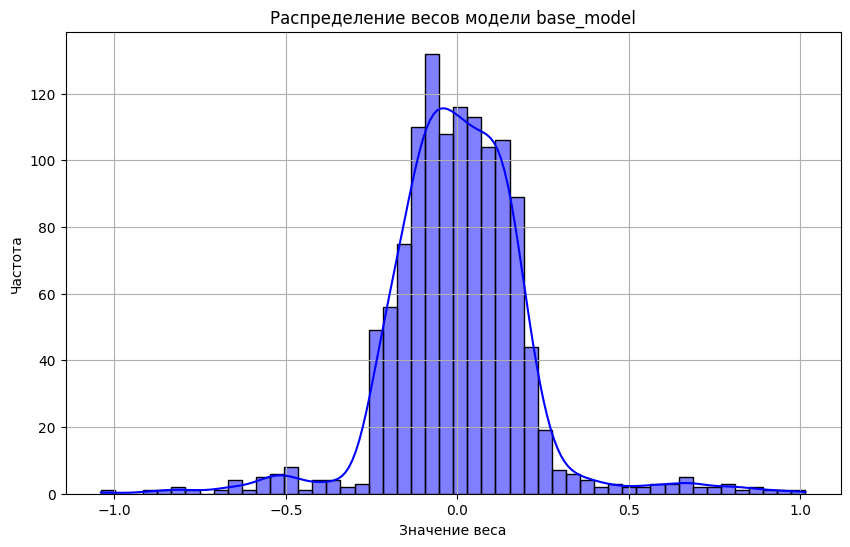

In [18]:
base_model = nn.Sequential(nn.Linear(11,16),
                            nn.Linear(16,32),
                            nn.Linear(32,16),
                            nn.Linear(16,1))

dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")

model_name = "base_model"
train_model_with_accurasy(dataset,base_model,model_name)
plot_weight_histogram_sequential(base_model,model_name)

Добавим различные Dropout


Starting training...
Epoch 1/(50,), Train Loss: 0.479811, Val Loss: 0.471272
Epoch 21/(50,), Train Loss: 0.459498, Val Loss: 0.452209
Epoch 41/(50,), Train Loss: 0.470348, Val Loss: 0.492666


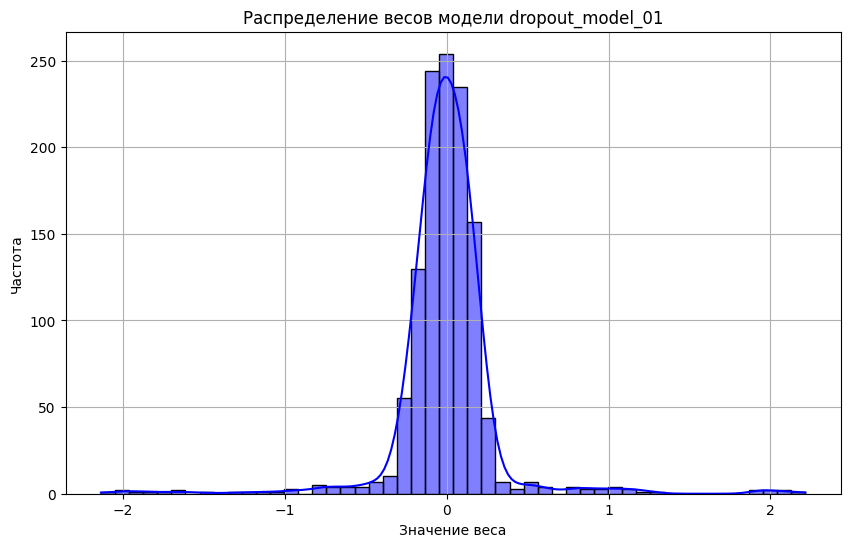

In [22]:
percent_Dropout = 0.1

dropout_model_01 = nn.Sequential(nn.Linear(11,16),nn.Dropout(percent_Dropout),
                            nn.Linear(16,32),nn.Dropout(percent_Dropout),
                            nn.Linear(32,16),nn.Dropout(percent_Dropout),
                            nn.Linear(16,1))

dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")

model_name = "dropout_model_01"
train_model_with_accurasy(dataset,base_model,model_name)
plot_weight_histogram_sequential(base_model,model_name)

Starting training...
Epoch 1/(50,), Train Loss: 0.505088, Val Loss: 0.484664
Epoch 21/(50,), Train Loss: 0.451029, Val Loss: 0.455853
Epoch 41/(50,), Train Loss: 0.478754, Val Loss: 0.489701


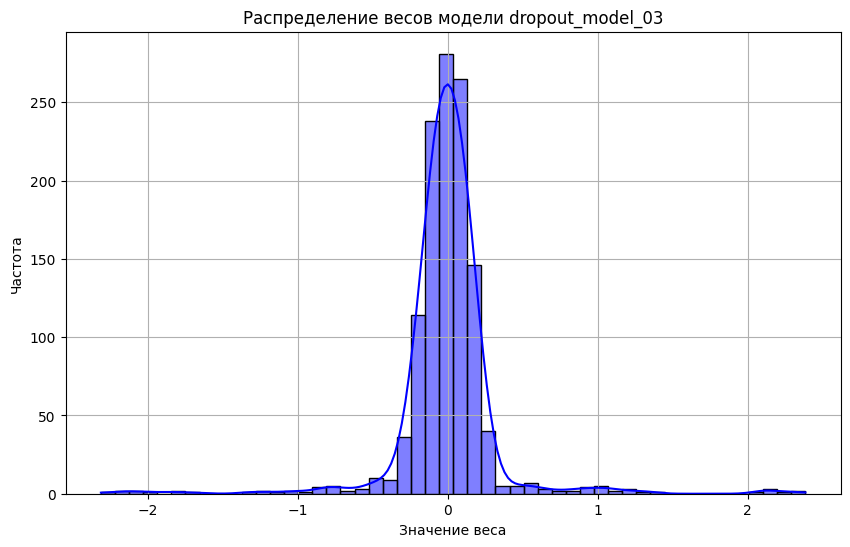

In [23]:
percent_Dropout = 0.3

dropout_model_03 = nn.Sequential(nn.Linear(11,16),nn.Dropout(percent_Dropout),
                            nn.Linear(16,32),nn.Dropout(percent_Dropout),
                            nn.Linear(32,16),nn.Dropout(percent_Dropout),
                            nn.Linear(16,1))

dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")

model_name = "dropout_model_03"
train_model_with_accurasy(dataset,base_model,model_name)
plot_weight_histogram_sequential(base_model,model_name)

Starting training...
Epoch 1/(50,), Train Loss: 0.485482, Val Loss: 0.459854
Epoch 21/(50,), Train Loss: 0.445560, Val Loss: 0.520376
Epoch 41/(50,), Train Loss: 0.477310, Val Loss: 0.469700


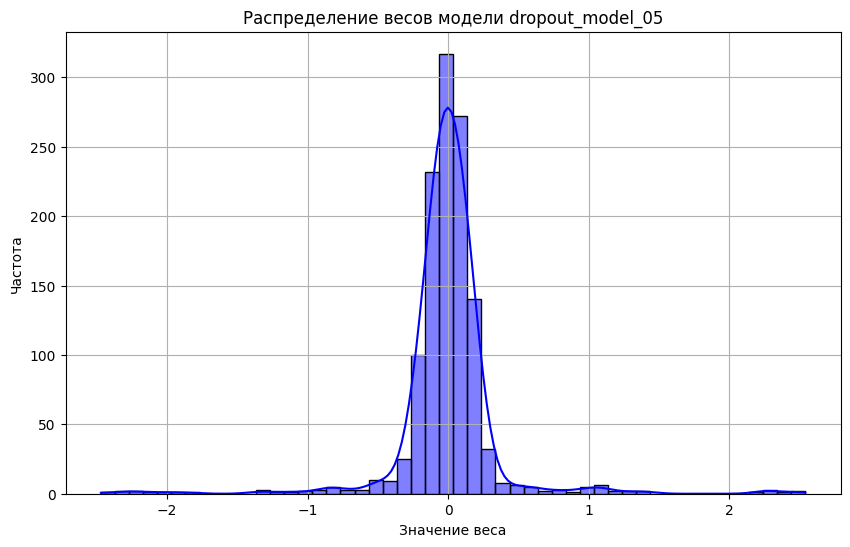

In [24]:
percent_Dropout = 0.5

dropout_model_05 = nn.Sequential(nn.Linear(11,16),nn.Dropout(percent_Dropout),
                            nn.Linear(16,32),nn.Dropout(percent_Dropout),
                            nn.Linear(32,16),nn.Dropout(percent_Dropout),
                            nn.Linear(16,1))

dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")

model_name = "dropout_model_05"
train_model_with_accurasy(dataset,base_model,model_name)
plot_weight_histogram_sequential(base_model,model_name)

Теперь BatchNorm

Starting training...
Epoch 1/(50,), Train Loss: 0.492459, Val Loss: 0.509778
Epoch 21/(50,), Train Loss: 0.443542, Val Loss: 0.473974
Epoch 41/(50,), Train Loss: 0.443494, Val Loss: 0.492823


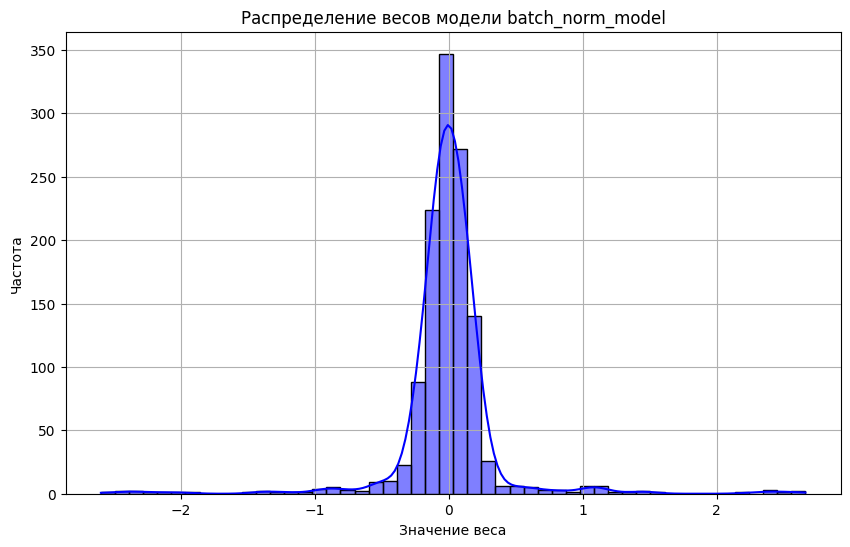

In [25]:
batch_norm_model = nn.Sequential(nn.Linear(11,16),nn.BatchNorm1d(16),
                            nn.Linear(16,32),nn.BatchNorm1d(32),
                            nn.Linear(32,16),nn.BatchNorm1d(16),
                            nn.Linear(16,1))

dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")

model_name = "batch_norm_model"
train_model_with_accurasy(dataset,base_model,model_name)
plot_weight_histogram_sequential(base_model,model_name)

Dropout + BatchNorm

Starting training...
Epoch 1/(50,), Train Loss: 0.458578, Val Loss: 0.481946
Epoch 21/(50,), Train Loss: 0.432501, Val Loss: 0.470565
Epoch 41/(50,), Train Loss: 0.454926, Val Loss: 0.463755


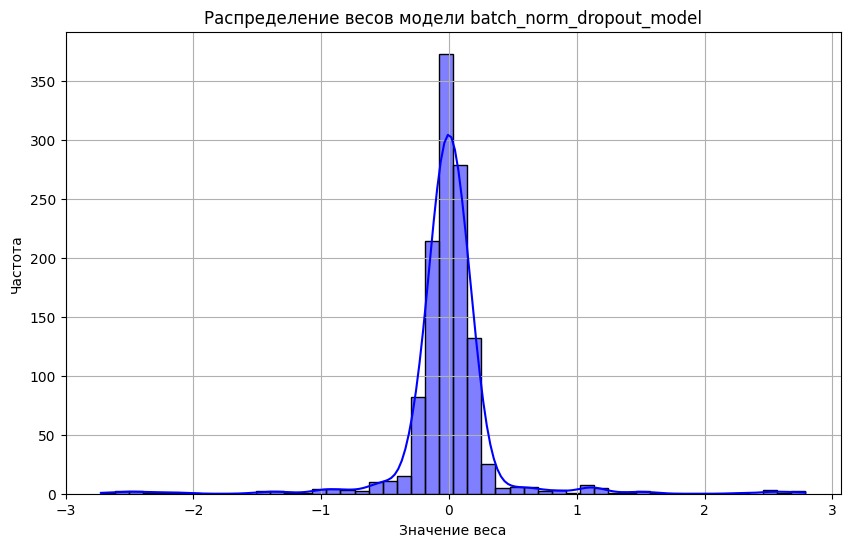

In [26]:
percent_Dropout = 0.1

batch_norm_dropout_model = nn.Sequential(nn.Linear(11,16),nn.Dropout(percent_Dropout),nn.BatchNorm1d(16),
                            nn.Linear(16,32),nn.Dropout(percent_Dropout),nn.BatchNorm1d(32),
                            nn.Linear(32,16),nn.Dropout(percent_Dropout),nn.BatchNorm1d(16),
                            nn.Linear(16,1))

dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")

model_name = "batch_norm_dropout_model"
train_model_with_accurasy(dataset,base_model,model_name)
plot_weight_histogram_sequential(base_model,model_name)

Как ни странно лучше всего себя показала базовая модель,возможно это из-за небольшого количества данных